In [5]:
import pytorch_pretrained_bert as ppbert
from enchant.checker import SpellChecker
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
import pytesseract
import torch
import nltk
import cv2
import re

In [6]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

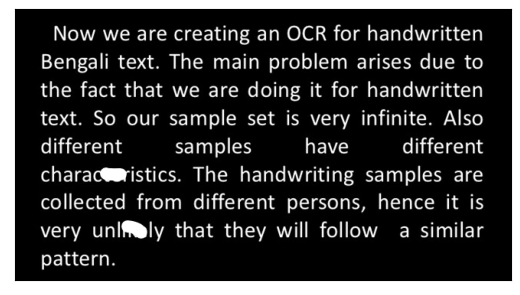

In [7]:
# Image Processing to enhance PyTesseract scaning

path = './testeo7.png'

def image_processing(path):
    try:
        gray_image = cv2.imread(path, 0)
        gray_image_negative = abs(255-gray_image)

        plt.imshow(gray_image_negative, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.show()

        #save the negative image
        cv2.imwrite('image_processed_to_pytesseract.png', gray_image_negative)

        return gray_image_negative
    except:
        print("Error loading image")

gray_image_negative = image_processing(path)

In [8]:
#Extract and find characteres
aux_text = pytesseract.image_to_string(gray_image_negative)
original_text = str(aux_text)
print (original_text)

Now we are creating an OCR for handwritten
Bengali text. The main problem arises due to
the fact that we are doing it for handwritten
text. So our sample set is very infinite. Also
different samples have different
charac@@ristics. The handwriting samples are
collected from different persons, hence it is
very unlf~ly that they will follow a similar
pattern.



In [9]:
# regular expresions for tokenizer
regexp = { '\n': ' ', '\\': ' ', '\"': '"', '-': ' ', '"': ' " ', '"': ' " ', '"': ' " ', ',':' , ', '.':' . ', '!':' ! ', 
        '?':' ? ', "n't": " not" , "'ll": " will", '*':' * ', '(': ' ( ', ')': ' ) ', "s'": "s '"}

regexp = dict((re.escape(keys), values) for keys, values in regexp.items()) 
pat_recog_tok = re.compile("|".join(regexp.keys()))

aux_text = pat_recog_tok.sub(lambda mssg: regexp[re.escape(mssg.group(0))], aux_text)
aux_text

'Now we are creating an OCR for handwritten Bengali text .  The main problem arises due to the fact that we are doing it for handwritten text .  So our sample set is very infinite .  Also different samples have different charac@@ristics .  The handwriting samples are collected from different persons ,  hence it is very unlf~ly that they will follow a similar pattern .  '

In [10]:
phras=nltk.sent_tokenize(aux_text)
phras[3]

'Also different samples have different charac@@ristics .'

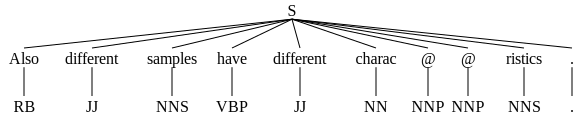

In [11]:
nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(phras[3])))

In [12]:
def name_persons_list(texto) -> list:
    nameslist=[]
    for sententence in nltk.sent_tokenize(texto):
        for tags in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sententence))):
            if isinstance(tags, nltk.tree.Tree) and tags.label() == 'PERSON':
                nameslist.insert(0, (tags.leaves()[0][0]))
    return list(set(nameslist))
    
nameslist = name_persons_list(aux_text)
words_to_ignore = nameslist + ["!", ",", ".", "\"", "?", '(', ')', '*', "'"]
words_to_ignore

['!', ',', '.', '"', '?', '(', ')', '*', "'"]

In [13]:
# Incorrect words
spellcheck = SpellChecker("en_US")
sep_w = aux_text.split()

anomaly_words = [word for word in sep_w if not spellcheck.check(word) and word not in words_to_ignore]
print(anomaly_words)
print()

# recommended words to replace
recommended_words = [spellcheck.suggest(word) for word in anomaly_words]
print(recommended_words)
print()

for word in anomaly_words:
    aux_text = aux_text.replace(word, '[MASK]')
    original_text = original_text.replace(word, '[MASK]')
    
print(aux_text)

['charac@@ristics', 'unlf~ly']

[['characteristics', 'characteristic'], ['unlikely']]

Now we are creating an OCR for handwritten Bengali text .  The main problem arises due to the fact that we are doing it for handwritten text .  So our sample set is very infinite .  Also different samples have different [MASK] .  The handwriting samples are collected from different persons ,  hence it is very [MASK] that they will follow a similar pattern .  


In [14]:
tk = ppbert.BertTokenizer.from_pretrained('bert-large-uncased')

text_toknd = tk.tokenize(aux_text)
text_toknd = [text for text in text_toknd if text!="."]

idx_toknd= tk.convert_tokens_to_ids(text_toknd)
IDS_FOW = [idx for idx, wd in enumerate(text_toknd) if wd == '[MASK]']

segments = [idx for idx, wd in enumerate(text_toknd) if wd == "."]
ids_seg=[]
w_prior=-1

for key, sentnc in enumerate(segments):
    ids_seg = ids_seg + [key] * (sentnc-w_prior)
    w_prior=sentnc

ids_seg = ids_seg + [len(segments)] * (len(text_toknd) - len(ids_seg))
sgms_tensor= torch.tensor([ids_seg])

tkns_tensor = torch.tensor([idx_toknd]) # token tensor input

with torch.no_grad():
    output_pred = ppbert.BertForMaskedLM.from_pretrained('bert-large-uncased')(tkns_tensor, sgms_tensor)

In [15]:
output_pred

tensor([[[ -8.2693,  -8.7218,  -8.8227,  ...,  -8.2388,  -7.9942,  -3.0627],
         [ -8.0813,  -7.3614,  -8.0224,  ...,  -6.2643,  -7.4878,  -4.2239],
         [-12.5148, -11.4538, -12.3092,  ..., -10.0459, -11.0257,  -5.9309],
         ...,
         [-14.7263, -14.8833, -14.7563,  ..., -12.7663, -15.4032,  -6.6627],
         [ -5.8339,  -5.7639,  -5.4189,  ...,  -6.4139,  -4.9907,  -7.5867],
         [ -6.7516,  -6.4318,  -5.9816,  ...,  -5.7648,  -5.2172,  -7.7006]]])

In [16]:
original_text

'Now we are creating an OCR for handwritten\nBengali text. The main problem arises due to\nthe fact that we are doing it for handwritten\ntext. So our sample set is very infinite. Also\ndifferent samples have different\n[MASK]. The handwriting samples are\ncollected from different persons, hence it is\nvery [MASK] that they will follow a similar\npattern.\n'

In [17]:
def pred_correct_words(original_text, output_pred, IDS_FOW) -> str:
    print("========== RECOMMENDED WORDS ==========")

    for index in range(len(IDS_FOW)):
        predictions = torch.topk(output_pred[0, IDS_FOW[index]], k=50) 
        inds = predictions.indices.tolist()
        ltk1 = tk.convert_ids_to_tokens(inds) #list 1
        ltk2 = recommended_words[index] #list 2
        max_sims=0 ; tokens_pred=''

        for ws1 in ltk1: #ws: word of sentence 1
            for ws2 in ltk2:
                sequencem = SequenceMatcher(None, ws1, ws2).ratio()
                if sequencem is not None and sequencem > max_sims:
                    max_sims = sequencem
                    tokens_pred = ws1

        print("=> " + tokens_pred)
        original_text = original_text.replace('[MASK]', tokens_pred, 1)

    return original_text

original_text = pred_correct_words(original_text, output_pred, IDS_FOW)
print("\n=========== ORGINAL TEXT - FORMAT ================")
print (original_text)

========== RECOMMENDED WORDS ==========
=> characteristics
=> unlikely

=========== ORGINAL TEXT - FORMAT ================
Now we are creating an OCR for handwritten
Bengali text. The main problem arises due to
the fact that we are doing it for handwritten
text. So our sample set is very infinite. Also
different samples have different
characteristics. The handwriting samples are
collected from different persons, hence it is
very unlikely that they will follow a similar
pattern.

